In [65]:
import numpy as np
import os
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, make_scorer
from dataPreprocessing import DataPreprocessing

# classifiers
from classification.ElkanotoSVCClassifier import ElkanotoSVCClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# feature selection
from sklearn.decomposition import PCA

# Classification pipeline

In [113]:
# Global parameters
doPreprocessing = False # whether to generate the files for those feature sets
featureSets = [{ "kmer_simple": [3, 6]},
               { "kmer_simple": [3] },
               { "kmer_simple": [6] },
               { "kmer": [3, 6] },
               { "kmer": [2, 3, 6] }]

# define data to use
hostsToIncludeInTrainingData = [10036, 10090, 1644094, 9031, 9455, 9534, 9544, 9823, 9913]
# hostsToIncludeInTrainingData = [10090, 1644094, 9031, 9455, 9534, 9544, 9823, 9913]
hostsToBuildClassifierFor = [10036]
# hostsToBuildClassifierFor = [9455]
featureFileToUse = "features_kmer-3-6.csv"

# paths
featureFileFolder = "../features"
featureFilePrefix = "features"
genomeParentFolder = "../viral_genomes"

# fix randomness
randomState = 42

In [3]:
# Preprocessing means regenerating the feature files for the chosen feature sets
if doPreprocessing:
    # get all hosts
    allHosts = [f.name for f in os.scandir(genomeParentFolder) if f.is_dir()]
    filesForHosts = {host: [f.name for f in os.scandir(f"{genomeParentFolder}/" + host) if f.is_file()] for host in allHosts}

    # filter out files that exist in multiple hosts
    nonUnique = set()
    for host in allHosts:
        for otherHost in allHosts:
            if host != otherHost:
                appearInBoth = set(filesForHosts[host]).intersection(set(filesForHosts[otherHost]))
                nonUnique = nonUnique.union(appearInBoth)
    for host in allHosts:
        filesForHosts[host] = [f for f in filesForHosts[host] if f not in nonUnique]

    # create feature files
    for featureSet in featureSets:
        # feature file suffix
        suffix = ""
        for k, v in featureSet.items():
            suffix += f"_{k}"
            for val in v:
                suffix += f"-{val}"
        print("Creating feature set " + suffix)

        # extract features
        with open(f"{featureFileFolder}/{featureFilePrefix}{suffix}.csv", "w") as featureFile:
            dataPreprocessor = DataPreprocessing.DataPreprocessing()
            for host in allHosts:
                print ("Extracting features for host: " + host)
                for genomeFilename in filesForHosts[host]:
                    with open(f"{genomeParentFolder}/{host}/{genomeFilename}", "r") as genomeFile:
                        # get sequence
                        lines = genomeFile.readlines()
                        sequence = "".join(lines[1:]).replace("\n", "")
                        # flatten feature dict to list
                        features = [x for v in dataPreprocessor.extractFeaturesFromGenome(sequence, featureSet).values() for x in v]
                        # write as csv
                        featureFile.write(host + "," + genomeFilename.split(".")[0] + "," + ",".join(map(str, features)) + "\n")

In [114]:
# Create dictionary of hosts (as key) and lists (of feature lists for each virus) (as value)
featuresPerHost = {}
for host in hostsToIncludeInTrainingData:
    featuresPerHost[host] = []

# Load features of virus sequences for each host in seperate list and convert them to a np array
print("Loading features")
with open(f"{featureFileFolder}/{featureFileToUse}") as featureFile:
    for line in featureFile:
        # split csv
        values = line.rstrip().split(",")
        # get host
        host = int(values[0])
        if host in hostsToIncludeInTrainingData:
            # if host should be loaded, save features for this virus
            featuresPerHost[host].append(list(map(float, values[2:])))
for host in hostsToIncludeInTrainingData:
    featuresPerHost[host] = np.array(featuresPerHost[host])

Loading features


In [115]:
# choose classifiers
classifiers = {}
for host in hostsToBuildClassifierFor:
    # classifiers[host] = DecisionTreeClassifier(random_state=randomState)
    # classifiers[host] = KNeighborsClassifier(n_neighbors=7)
    # classifiers[host] = ElkanotoSVCClassifier(hold_out_ratio=0.1, threshold=0.5, random_state = randomState)
    classifiers[host] = SVC(kernel = 'rbf', random_state = randomState)

# Transform features (X) and host classes (y) into expected format for classifier
# exclude hosts that have no values in the training data
X = np.concatenate([featuresPerHost[host] for host in hostsToIncludeInTrainingData if featuresPerHost[host].shape[0] > 0])

# # reduce dimensionality
# X = PCA(n_components=15, random_state=randomState).fit_transform(X)

def getYForHost(h):
    y = []
    for host in hostsToIncludeInTrainingData:
        y += [1 if host == h else 0] * len(featuresPerHost[host])
    return np.array(y)

scores = {}
specificity = make_scorer(recall_score, pos_label=0)
for host in hostsToBuildClassifierFor:
    print("Running cross validation for host:", host)
    # load the training data
    X = X
    y = getYForHost(host)

    # run k-fold cross validation
    cv = KFold(n_splits=4, shuffle=True, random_state=randomState)
    scores[host] = cross_validate(classifiers[host], X, y, cv=cv, n_jobs=4, scoring={'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall', 'specificity': specificity, 'precision': 'precision', 'f1': 'f1'})

Running cross validation for host: 10036


Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.79 [0.77101833 0.77705793 0.78901789 0.82170099]
Recall: 0.6 [0.55696203 0.58536585 0.5915493  0.65789474]
Specificity: 0.98 [0.98507463 0.96875    0.98648649 0.98550725]
Precision: 0.97 [0.97777778 0.96       0.97674419 0.98039216]
F1: 0.74 [0.70967742 0.72727273 0.73684211 0.78740157]


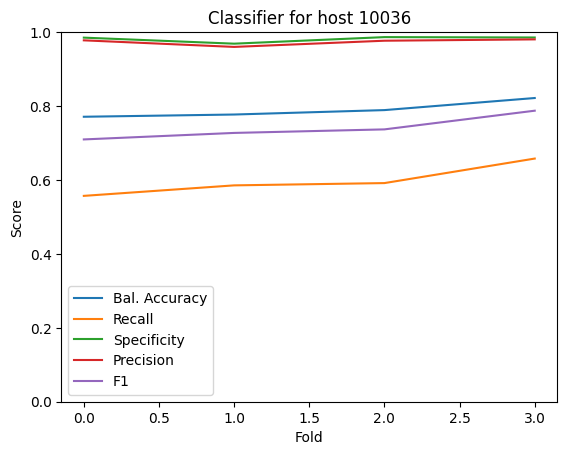

In [116]:
# Plot results
import matplotlib.pyplot as plt

for host in hostsToBuildClassifierFor:
    print("Results for host:", host)
    print("Feature file:", featureFileToUse)
    print("Balanced accuracy:", round(np.mean(scores[host]['test_balanced_accuracy']), 2), scores[host]['test_balanced_accuracy'])
    print("Recall:", round(np.mean(scores[host]['test_recall']), 2), scores[host]['test_recall'])
    print("Specificity:", round(np.mean(scores[host]['test_specificity']), 2), scores[host]['test_specificity'])
    print("Precision:", round(np.mean(scores[host]['test_precision']), 2), scores[host]['test_precision'])
    print("F1:", round(np.mean(scores[host]['test_f1']), 2), scores[host]['test_f1'])

    plt.plot(scores[host]['test_balanced_accuracy'], label='Bal. Accuracy')
    plt.plot(scores[host]['test_recall'], label='Recall')
    plt.plot(scores[host]['test_specificity'], label='Specificity')
    plt.plot(scores[host]['test_precision'], label='Precision')
    plt.plot(scores[host]['test_f1'], label='F1')

    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Fold")

    plt.legend()
    plt.title(f"Classifier for host {host}")
    plt.show()

# Research

['10036', '10090', '1644094', '9031', '9455', '9534', '9544', '9823', '9913']


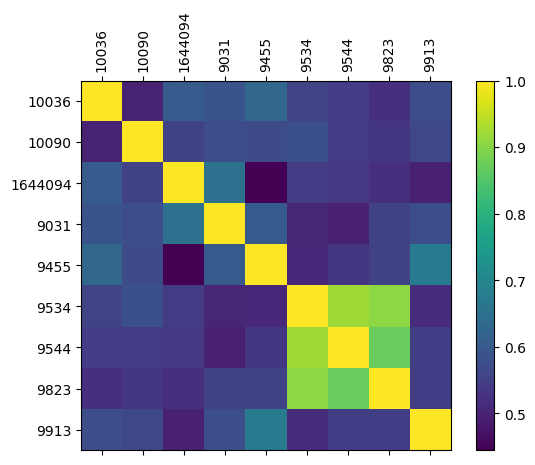

In [118]:
# Research how many viruses overlap between hosts
import os
import matplotlib.pyplot as plt

allHosts = [f.name for f in os.scandir(genomeParentFolder) if f.is_dir()]
filesForHosts = {host: [f.name for f in os.scandir(f"{genomeParentFolder}/{host}") if f.is_file()] for host in allHosts}
print(allHosts)

# create a confustion matrix of the host files
confusionMatrix = []
for i, host in enumerate(allHosts):
    confusionMatrix.append([0] * len(allHosts))
    for j, host2 in enumerate(allHosts):
        confusionMatrix[i][j] = len(set(filesForHosts[host]).intersection(set(filesForHosts[host2]))) / min(len(filesForHosts[host]), len(filesForHosts[host2]))

# plot heatmap
fig, ax = plt.subplots()
cax = ax.matshow(confusionMatrix)
fig.colorbar(cax)
plt.xticks(range(len(allHosts)), allHosts, rotation=90)
plt.yticks(range(len(allHosts)), allHosts)
plt.show()

We can see that there is at least a ~45% overlap for each host.

## Researching how balanced the input data is

Ideally we want to train a classifier on balanced input data.

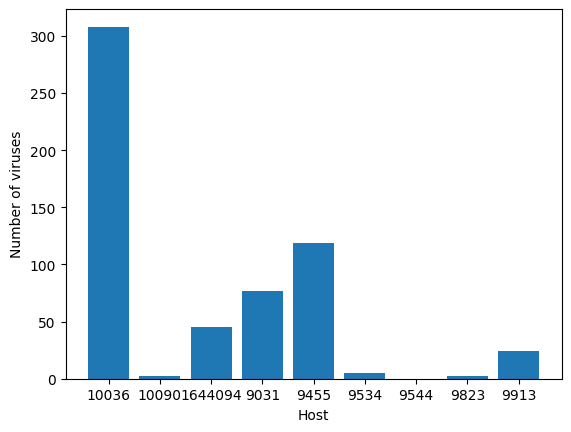

In [96]:
# plot histogram

x = list(map(str, featuresPerHost.keys()))
y = [len(featuresPerHost[int(host)]) for host in x]
plt.bar(x, y)
plt.xlabel("Host")
plt.ylabel("Number of viruses")
plt.show()

As we can see, the most balance predictor uses 10036 as the positive samples, and the others as the negative ones.

Another potentially viable combination would be excluding 10036 (bc it has so many viruses) and trying to build a classifier for 9455. This yields the following result:
```
Results for host: 9455
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.59 [0.59137931 0.60186757 0.59437229 0.56684982]
Recall: 0.5 [0.48275862 0.67741935 0.3030303  0.53846154]
Specificity: 0.68 [0.7        0.52631579 0.88571429 0.5952381 ]
Precision: 0.56 [0.53846154 0.53846154 0.71428571 0.4516129 ]
F1: 0.51 [0.50909091 0.6        0.42553191 0.49122807]
```

As we can see the performance is relatively bad, probably in part due to a lack of training data. Including 10036 as negative samples led to a classifier always predicting 0.

Therefore, the only viable solution given the data is a predictor for 10036.

## Fine-tuning the features and model

Results from different runs USING SVC WITH RBF-KERNEL
```
Results for host: 10036
Feature file: features_kmer_simple-3-6.csv
Balanced accuracy: 0.79 [0.77101833 0.78658537 0.77464789 0.82236842]
Recall: 0.58 [0.55696203 0.57317073 0.54929577 0.64473684]
Specificity: 1.0 [0.98507463 1.         1.         1.        ]
Precision: 0.99 [0.97777778 1.         1.         1.        ]
F1: 0.73 [0.70967742 0.72868217 0.70909091 0.784     ]

Results for host: 10036
Feature file: features_kmer_simple-3.csv
Balanced accuracy: 0.78 [0.77101833 0.78658537 0.76056338 0.79996186]
Recall: 0.58 [0.55696203 0.57317073 0.52112676 0.65789474]
Specificity: 0.98 [0.98507463 1.         1.         0.94202899]
Precision: 0.98 [0.97777778 1.         1.         0.92592593]
F1: 0.72 [0.70967742 0.72868217 0.68518519 0.76923077]

Results for host: 10036
Feature file: features_kmer_simple-6.csv
Balanced accuracy: 0.77 [0.78254298 0.77096037 0.75437762 0.77097635]
Recall: 0.59 [0.59493671 0.57317073 0.54929577 0.65789474]
Specificity: 0.95 [0.97014925 0.96875    0.95945946 0.88405797]
Precision: 0.93 [0.95918367 0.95918367 0.92857143 0.86206897]
F1: 0.72 [0.734375   0.71755725 0.69026549 0.74626866]
```
From the above results we can see that the codon frequencies contain the most vital information and the di-codon frequences do not add much to classification performance.

```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.79 [0.77101833 0.77705793 0.78901789 0.82170099]
Recall: 0.6 [0.55696203 0.58536585 0.5915493  0.65789474]
Specificity: 0.98 [0.98507463 0.96875    0.98648649 0.98550725]
Precision: 0.97 [0.97777778 0.96       0.97674419 0.98039216]
F1: 0.74 [0.70967742 0.72727273 0.73684211 0.78740157]

Results for host: 10036
Feature file: features_kmer-2-3-6.csv
Balanced accuracy: 0.77 [0.76761761 0.74676067 0.78311762 0.78480168]
Recall: 0.63 [0.59493671 0.63414634 0.63380282 0.67105263]
Specificity: 0.91 [0.94029851 0.859375   0.93243243 0.89855072]
Precision: 0.89 [0.92156863 0.85245902 0.9        0.87931034]
F1: 0.74 [0.72307692 0.72727273 0.74380165 0.76119403]
```
We can see that also including the reverse complement does not influence performance substanially, therefore it will be included in further analysis as this potentially allows to feed the algorithm queries where it is not known if it is the reverse complement of the sequence or not.

@FLO I removed the invalid kmer frequencies, as this does not impact performance at all and is really dependent on sequencing and not the virus itself.

Including the dinucleotide frequency does not substantually improve recall while reducing specificity, therefore this will not further be done.

The best feature selection therefore seems to be: codon + dicodon frequencies, including the reverse complement of the strand.

Using the ElkanotoSVCClassifier with hold_out_ratio=0.1 and threshold=0.5 we get the following:
```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.7 [0.7029095  0.71646341 0.65816521 0.71157513]
Recall: 0.76 [0.73417722 0.68292683 0.8028169  0.82894737]
Specificity: 0.63 [0.67164179 0.75       0.51351351 0.5942029 ]
Precision: 0.7 [0.725      0.77777778 0.61290323 0.69230769]
F1: 0.73 [0.72955975 0.72727273 0.69512195 0.75449102]
```

Which gives us better recall, but worse specificity.

Using other classifiers based on KNeigbors and a DecisionTree did not yield better results than using the SVC.

Using the SCV with a preceding PCA with 15 components:
```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.78 [0.79000567 0.77877287 0.75494861 0.79729214]
Recall: 0.61 [0.59493671 0.57317073 0.57746479 0.71052632]
Specificity: 0.95 [0.98507463 0.984375   0.93243243 0.88405797]
Precision: 0.93 [0.97916667 0.97916667 0.89130435 0.87096774]
F1: 0.74 [0.74015748 0.72307692 0.7008547  0.7826087 ]
```
We can see that the specificity decreases in comparison to using no PCA, while there is no real improvment in the other metrics.

Trying out other hyperparameters for the SVC, namely different kernels and regularization parameters, did also not yield any improvement.

In conclusion, the best performance was reached using a SVC with RBF kernel and default parameters, on the codon and dicodon frequencies including the reverse complement.
```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.79 [0.77101833 0.77705793 0.78901789 0.82170099]
Recall: 0.6 [0.55696203 0.58536585 0.5915493  0.65789474]
Specificity: 0.98 [0.98507463 0.96875    0.98648649 0.98550725]
Precision: 0.97 [0.97777778 0.96       0.97674419 0.98039216]
F1: 0.74 [0.70967742 0.72727273 0.73684211 0.78740157]
```

# Old results (for future reference)

In [ ]:
# Elkanoto w/o unique virus filtering (+ different features)
# elkanoto_svc_results = {1644094: {'fit_time': array([4907.15073395, 4990.56171942, 4950.51426482, 4881.92315793]), 'score_time': array([1155.61685181, 1191.37233377, 1176.45055175, 1254.34660721]), 'test_balanced_accuracy': array([0.5       , 0.5       , 0.5       , 0.50102549]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0.        , 0.        , 0.        , 0.00205098]), 'test_precision': array([0.11694696, 0.123674  , 0.11875809, 0.11715915]), 'test_f1': array([0.20940468, 0.22012434, 0.21230342, 0.20974478])}, 10090: {'fit_time': array([534.51305532, 619.46996903, 592.92223024, 604.51297069]), 'score_time': array([187.53446698, 171.91070223, 181.0747714 , 168.35237956]), 'test_balanced_accuracy': array([0.5       , 0.61592175, 0.5       , 0.38738078]),'test_recall': array([1.        , 0.94230769, 1.        , 0.68965517]), 'test_specificity': array([0.        , 0.2895358 , 0.        , 0.08510638]), 'test_precision': array([0.01552393, 0.0177665 , 0.01655886, 0.01135396]), 'test_f1': array([0.03057325, 0.03487544, 0.03257826, 0.02234013])}, 10036: {'fit_time': array([8393.32273841, 8297.76433659, 8338.97264695, 8418.57178783]), 'score_time': array([1768.69770193, 1731.56972361, 1732.82323742, 1774.01409435]), 'test_balanced_accuracy': array([0.49907882, 0.49741666, 0.50031706, 0.49821664]), 'test_recall': array([0.99563953, 0.99008499, 1.        , 0.9954955 ]), 'test_specificity': array([0.0025181 , 0.00474834, 0.00063412, 0.00093779]), 'test_precision': array([0.17773742, 0.18188915, 0.18405384, 0.17180617]), 'test_f1': array([0.30162924, 0.30732029, 0.31088763, 0.29303867])}, 9913: {'fit_time': array([4604.48881054, 4645.48022342, 4221.3886528 , 4642.48942566]), 'score_time': array([1108.71009684, 1121.05930471, 1162.92115974, 1088.92917538]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0., 0., 0., 0.]), 'test_precision': array([0.11228978, 0.11021992, 0.12005175, 0.10349288]), 'test_f1': array([0.20190742, 0.19855512, 0.21436821, 0.18757327])}, 9823: {'fit_time': array([3012.83791757, 3059.24084091, 3229.53498507, 3181.73191714]), 'score_time': array([799.33551478, 842.05273533, 808.06591558, 797.54948783]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0., 0., 0., 0.]), 'test_precision': array([0.08667529, 0.08382924, 0.07218629, 0.07270375]), 'test_f1': array([0.15952381, 0.15469086, 0.13465251, 0.13555234])}, 9544: {'fit_time': array([3095.12177825, 2976.99537325, 3123.85219169, 3244.73573923]),'score_time': array([774.44141483, 845.29702067, 806.54878998, 806.88626552]), 'test_balanced_accuracy': array([0.5       , 0.5       , 0.50013959, 0.50055975]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0.        , 0.        , 0.00027917, 0.00111951]), 'test_precision': array([0.08279431, 0.08150065, 0.07324017, 0.07562808]), 'test_f1': array([0.15292712, 0.1507177 , 0.13648421, 0.14062124])}, 9534: {'fit_time': array([3538.9825871 , 3668.4609971 , 3604.55383062, 3706.58384895]), 'score_time': array([952.44729257, 889.66033769, 911.11520481, 914.77577758]), 'test_balanced_accuracy': array([0.54417822, 0.5       , 0.52842069, 0.5       ]), 'test_recall': array([0.98680739, 1.        , 0.99125364, 1.        ]), 'test_specificity':array([0.10154905, 0.        , 0.06558773, 0.        ]), 'test_precision': array([0.10667427, 0.09003881, 0.09363812, 0.0915912 ]), 'test_f1': array([0.19253539, 0.16520294, 0.17111223, 0.16781228])}, 9455: {'fit_time': array([6848.16912031, 7427.41147518, 7640.42564702, 7323.24975252]), 'score_time': array([1687.09556961, 1779.03239751, 1698.843575  , 1638.78948259]), 'test_balanced_accuracy': array([0.50172847, 0.50131404, 0.50046282, 0.50387237]), 'test_recall': array([1.        , 0.99366086, 1.        , 1.        ]), 'test_specificity': array([0.00345695, 0.00896722, 0.00092564, 0.00774473]), 'test_precision': array([0.17721847, 0.16362213, 0.16157431, 0.16588542]), 'test_f1': array([0.30108001, 0.28097692, 0.27819884, 0.28456556])}, 9031: {'fit_time': array([7942.13983655, 7360.12914085, 7180.73114204, 8050.09637523]), 'score_time': array([1712.94993877, 1640.6033814 , 1590.65490031, 1658.59115052]),'test_balanced_accuracy': array([0.50491899, 0.50329869, 0.50630963, 0.50232414]), 'test_recall': array([0.99840764, 0.99655172, 1.        , 1.        ]), 'test_specificity': array([0.01143034, 0.01004566, 0.01261927, 0.00464828]), 'test_precision': array([0.1638359 , 0.15091384, 0.16108787, 0.16571429]), 'test_f1': array([0.28148148, 0.26213152, 0.27747748, 0.28431373])}}
# SVC w/o unique virus filtering (+ different features)
# svc_results = {1644094: {'fit_time': array([921.37710714, 804.73525739, 849.66964531, 926.64888024]), 'score_time': array([1414.27110267, 1283.12198019, 1460.35749292,1442.47194767]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 10090: {'fit_time': array([101.54810452, 157.45918989, 150.07447815,154.34451008]), 'score_time': array([200.94267321, 192.54084754, 195.76825142, 193.88725185]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 10036: {'fit_time': array([1371.72377682, 1347.67116475, 1320.66009974, 1371.74286461]), 'score_time': array([2003.450207  , 2182.99576569, 2356.71167111, 2530.73926139]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9913: {'fit_time': array([790.12615657, 759.92083788, 729.9546597 , 752.15770316]), 'score_time': array([1260.32520485, 1186.58301377, 1169.35508847, 1281.872684  ]), 'test_balanced_accuracy': array([0.5, 0.5,0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9823: {'fit_time': array([416.86714387, 610.88384724, 535.68782258, 586.4245491 ]), 'score_time': array([879.4391768 , 845.10344362, 930.64229822, 862.7680912 ]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9544: {'fit_time': array([507.69800401, 496.05915666, 523.17737341, 523.77310085]), 'score_time': array([866.88913274, 864.84455323, 894.51292753, 860.77611113]), 'test_balanced_accuracy': array([0.5, 0.5,0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9534: {'fit_time': array([601.23839355, 578.76752949, 597.39624858, 590.59732056]), 'score_time': array([1037.36745787, 1008.62105083,  985.8596127 , 1005.7146101 ]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity':array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9455: {'fit_time': array([1083.14667535, 1084.87314177, 1117.90640569, 1054.55059648]), 'score_time': array([1865.39292979, 1863.74345636, 1849.86681223, 1859.77698636]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]),'test_f1': array([0., 0., 0., 0.])}, 9031: {'fit_time': array([ 988.47512722, 1004.13777328, 1036.66497159, 1018.71995115]), 'score_time': array([1729.89951301, 1717.98967385, 1814.62169409, 1829.67017055]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}}